# Face Recognition using LBPH with Data Augmentation and Parameter Tuning

In [1]:
import cv2
import os
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

## Function to Read Images and Labels

In [2]:
def read_images_and_labels(dataset_path, img_size=(200, 200)):
    images = []
    labels = []
    label_map = {}
    label_counter = 0

    for person_name in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_path):
            continue

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            # Resize the image to ensure all images have the same dimensions
            image = cv2.resize(image, img_size)

            if person_name not in label_map:
                label_map[person_name] = label_counter
                label_counter += 1

            label = label_map[person_name]
            images.append(image)
            labels.append(label)

    return images, labels, label_map

## Function to Augment Data

In [3]:
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        # Flip horizontally
        flipped_image = cv2.flip(image, 1)
        augmented_images.append(flipped_image)
        augmented_labels.append(label)

        # Rotate
        rows, cols = image.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
        rotated_image = cv2.warpAffine(image, M, (cols, rows))
        augmented_images.append(rotated_image)
        augmented_labels.append(label)

        # Scale
        scaled_image = cv2.resize(image, (int(cols * 1.2), int(rows * 1.2)))
        scaled_image = cv2.resize(scaled_image, (cols, rows))
        augmented_images.append(scaled_image)
        augmented_labels.append(label)

    return augmented_images, augmented_labels

## Read Images and Labels

In [151]:
# Specify the path to your dataset
dataset_path = "dataset2"

# Read images and labels
images, labels, label_map = read_images_and_labels(dataset_path)

## Augment Data

In [161]:
# Augment data
images, labels = augment_data(images, labels)

## Convert to Numpy Arrays

In [162]:
# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

## Split Dataset into Train and Validation Sets

In [163]:
# encode the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split the dataset into train and validation sets (70:30)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

## Create LBPH Face Recognizer with Tuned Parameters

In [164]:
# Create the LBPH face recognizer with tuned parameters
recognizer = cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=8, grid_x=8, grid_y=8)

## Function to Calculate Accuracy and Custom Entropy Loss

In [156]:
def calculate_metrics(images, labels, num_classes):
    correct_predictions = 0
    log_loss_sum = 0
    epsilon = 1e-15  # Small value to prevent log(0)

    for i, image in enumerate(images):
        label, confidence = recognizer.predict(image)
        correct_predictions += (label == labels[i])

        # Simulate probability distributions for custom log loss
        predicted_prob = np.ones(num_classes) * (1 - confidence) / (num_classes - 1)
        predicted_prob[label] = confidence
        predicted_prob = np.clip(predicted_prob, epsilon, 1 - epsilon)
        predicted_prob /= predicted_prob.sum()

        true_prob = np.zeros(num_classes)
        true_prob[labels[i]] = 1

        log_loss_sum += -np.sum(true_prob * np.log(predicted_prob))
        #print(log_loss_sum)

    accuracy = correct_predictions / len(images)
    entropy_loss = log_loss_sum / len(images)
    return accuracy, entropy_loss

In [167]:
def calculate_metrics2(images, labels, num_classes):    
    print("[INFO] gathering predictions...")
    predictions = []
    confidences = []

    for i, image in enumerate(images):
      # classify the face and update the predictions
      # and confidence scores
      (prediction, confidence) = recognizer.predict(image)
      predictions.append(prediction)
      confidences.append(confidence)

    # show the classification report
    print(labels)
    print(predictions)
    print(classification_report(labels, predictions, target_names=le.classes_))

## Custom Training Loop with Logging

In [168]:
# Custom training loop with logging
num_epochs = 1  # Define the number of epochs
num_classes = len(np.unique(labels))  # Get the number of unique classes
print(num_classes)
for epoch in range(num_epochs):
    recognizer.train(train_images, train_labels)
    
    calculate_metrics2(train_images, train_labels, num_classes)
    calculate_metrics2(val_images, val_labels, num_classes)

    #train_accuracy, train_loss = calculate_metrics2(train_images, train_labels, num_classes)
    #val_accuracy, val_loss = calculate_metrics2(val_images, val_labels, num_classes)
    
    #print(f"Epoch {epoch + 1}/{num_epochs}")
    #print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    #print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    #print(f"Training Loss (Entropy): {train_loss:.4f}")
    #print(f"Validation Loss (Entropy): {val_loss:.4f}")
    #print("-")


3
[INFO] gathering predictions...
[0 2 1 2 0 1 2 1 1 1 0 0 2 2 1 1 2 1 0 1 2 1 1 1 1 2 2 1 0 2 2 0 0 0 0 1 0
 1 1 0 2 0 2 0 2 1 2 0 0 2 2 2 2 2 1 0 0 1 2 2 2 0 2 0 0 0 2 0 0 0 0 1 0 0
 1 1 1 0 1 0 0 1 0 2 2 1 0 1 0 0 0 1 1 1 0 2 1 0 0 2 0 0 1 1 0 2 1 2 0 0 1
 0 1 0 1 1 1 2 0 1 1 1 1 2 2 0 0 0 1 2 1 0 1 2 2 1 1 2 0 2 2 1 2 0 0 0 2 0
 0 0 0 2 0 0 0 0 1 2 0 1 2 1 1 1 1 1 0 1 1 1 1 1 1 0 0 2 2 2 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 1 0 0 2 2 2 2 1 2 1 0 0 1 1 0 0 1 2 1 2 2 2 1 0 0 0 2 0 2 0
 0 2 1 0 0 2 2 0 1 1 2 0 2 0 1 0 1 0 2 1 0 0 2 1 0 0 0 1 0 2 1 1 1 0 0 1 2
 0 2 2 0 0 0 0 0 2 2 2 2 0 1 1 0 0 1 2 0 0 2 2 0 0 2 0 1 1 2 0 0 2 2 2 1 1
 2 0 0 0 2 1 2 2 0 0 2 1 2 0 0 0 0 2 2 0 0 1 1 0 0 2 2 2 2 1 1 2 0 2 0 2 0
 0 1 0 2 2 1 1 1 0 2 2 0 0 2 1 2 0 0 0 2 0 1 2 2 2 2 0 2 2 1 2 2 1 2 0 2 0
 2 2 2 0 0 2 0 1 1 2 1 2 1 0 0 0 1 2 0 1 2 2 0 2 0 1 1 0 0 2 1 1 2 2 0 1 0
 1 0 2 1 2 1 2 1 2 0 0 2 2 2 1 0 1 0 0 0 2 1 0 2 0 1 0 0 1 0 0 0 1 0 1 2 2
 2 2 2 0 1 1 2 2 2 2 0 1 2 2 2 2 1 2 2 1 2 1 0 2 1 1 0 1 0 2 1 1 0

TypeError: object of type 'numpy.int64' has no len()

## Save the Recognizer Model and Label Map

In [41]:
# Save the trained model
recognizer.save('lbph_face_recognizer_model.yml')

# Save the label map
with open('label_map.pkl', 'wb') as f:
    pickle.dump(label_map, f)

Custom

In [ ]:
!pip install dlib-19.22.99-cp39-cp39-win_amd64.whl

In [ ]:
!pip install scipy
!pip install imutils
!pip install numpy


In [ ]:
!pip install numpy
!pip install matplotlib

In [16]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os

In [18]:
def face_detection(image):
  cascadePath = "haarcascade_frontalface_default.xml"
  detector = cv2.CascadeClassifier(cascadePath)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector.detectMultiScale(gray, scaleFactor=1.05,
	minNeighbors=10, minSize=(30, 30),
	flags=cv2.CASCADE_SCALE_IMAGE)

  return rects

In [29]:
def load_face_dataset(inputPath, minSamples = 15):
  # get all the image paths in the dataset folder structure and grab 
  # the name(i.e. groundtruth) of all the images and count each of them
  # and then put all of the groundtruths into a list
  imagePaths = list(paths.list_images(inputPath))
  names = [p.split(os.path.sep)[-2] for p in imagePaths]
  (names , counts) = np.unique(names , return_counts = True)
  names = names.tolist()

  faces = []
  labels = []
  bad = []

  # loop over all of the image paths
  for imagePath in imagePaths:
    # read the image and grab the image label
    image = cv2.imread(imagePath)
    name = imagePath.split(os.path.sep)[-2]
    # print('load_face_dataset img : '+ name)
    # check whether the count of this specific label is
    # below our minSamples threshold or not
    # if counts[names.index(name)] < minSamples:
    #  continue
    
    # perform face detection
    boxes = face_detection(image)
    
    if not np.any(boxes):
      bad.append(name)

    # loop over the bounding boxes
    for (x , y , w , h) in boxes:
      try:
        # extract the face ROI, resize it and convert
        # it into grayscale format
        faceROI = image[y:y+h , x:x+w]
        faceROI = cv2.resize(faceROI , (47 , 62))
        faceROI = cv2.cvtColor(faceROI , cv2.COLOR_BGR2GRAY)

        # update the faces and labels list
        faces.append(faceROI)
        labels.append(name)
      except:
        bad.append(name)
        continue
  # convert the faces and labels lists into Numpy array
  faces = np.array(faces)
  labels = np.array(labels)

  print('bad detect is ' )
  print(bad)
  return (faces , labels)

In [ ]:
#TEST
imagePaths = list(paths.list_images('data_db2'))
names = [p.split(os.path.sep)[-2] for p in imagePaths]
(names , counts) = np.unique(names , return_counts = True)
names = names.tolist()
print(names)

# loop over all of the image paths
for imagePath in imagePaths:
    name = imagePath.split(os.path.sep)[-2]
    print(name)

In [ ]:
!pip install seaborn

In [36]:
# confusion_matrix
from sklearn.metrics import confusion_matrix
from collections import Counter
import seaborn as sns

sns.set()

def cus_confusion_matrix(faces, y_test, y_predicted):
    #print(faces)
    print(y_test)
    print(y_predicted)
    
    # Step 1: Count the occurrences of each class in y_test
    class_counts = Counter(y_test)

    # Step 2: Sort the classes based on their counts in descending order and select the top 10
    top_10_classes = [class_label for class_label, _ in class_counts.most_common(10)]

    # For lowest counts, sort and select the bottom 10 classes
    #top_10_classes = [class_label for class_label, _ in class_counts.most_common()[-10:]]

    # Step 3: Map the selected classes to their corresponding labels
    top_10_labels = [labels[i] for i in top_10_classes]

    # Step 4: Filter y_test and y_pred based on the top 10 classes
    y_test_filtered = []
    y_pred_filtered = []

    for actual, predicted in zip(y_test, y_predicted):
        if actual in top_10_classes and predicted in top_10_classes:
            y_test_filtered.append(actual)
            y_pred_filtered.append(predicted)

    # Step 5: Calculate the confusion matrix with the filtered data
    cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=top_10_classes)

    # Plot the confusion matrix with correct labels
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=top_10_labels, yticklabels=top_10_labels)
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17)
    plt.show()

In [38]:
def cross_validation(input_data , cv = 5 , test_size = 0.30 , output = True , save_model=False):
  epoch = 0
  # initialize the f1-scores list
  f1_scores = []
  # grab some random numbers between 0 and 100
  #random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # Fixed
  random_states = [42]
  #print(random_states)

  # extract faces and label from dataset
  print('load_face_dataset')
  (faces , labels) = load_face_dataset(input_data)
  
  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # Count the number of instances per class
  label_counts = Counter(labels)
  print(random_states)
  print(labels)
  print(label_counts.values())
  
  # do the training process based on the number of 
  # random_states
  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state)
    
    # define and train the LBP model
    print("[INFO] training face recognizer...")
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

    start = time.time()
    recognizer.train(X_train , y_train)
    end = time.time()
    print("[INFO] training took {:.4f} seconds".format(end - start))

    # initialize our predictions and confidence lists
    print("[INFO] gathering predictions...")
    predictions = []
    confidences = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction, confidence) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidences.append(confidence)

    # measure how long making predictions took
    end = time.time()
    print("[INFO] inference took {:.4f} seconds".format(end - start))
    # print(confidences)
    # show the classification report
    print(classification_report(y_test, predictions, target_names=le.classes_))

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

    cus_confusion_matrix(faces, y_test, predictions)

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  print("[INFO] generate a sample of testing data")
  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = False)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("output/lbp-faces/face-{}.png".format(i))
    # save the model 
  
  if save_model:
    # save the model 
    recognizer.save("face-recognizer-model.yml")

  return f1_scores

In [39]:
f1_scores = cross_validation("data_db" , cv=5 , save_model=True)

load_face_dataset
bad detect is 
[]
[42]
[ 0  0  0 ... 46 46 46]
dict_values([20, 31, 30, 22, 21, 29, 20, 26, 26, 22, 23, 21, 21, 22, 30, 21, 20, 22, 22, 27, 30, 21, 21, 20, 21, 21, 24, 31, 23, 20, 24, 30, 24, 21, 22, 23, 29, 30, 24, 20, 20, 21, 29, 20, 20, 27, 20])
[INFO] training face recognizer...
[INFO] training took 13.9359 seconds
[INFO] gathering predictions...
[INFO] inference took 1800.6743 seconds
                              precision    recall  f1-score   support

      AISHWARYA_RAI_BACHCHAN       0.12      0.17      0.14         6
                       ALISA       0.60      0.67      0.63         9
                     ANUSORN       1.00      0.78      0.88         9
                      AYUWAT       0.78      1.00      0.88         7
      CHAITHAT_KULCHOKVANICH       0.75      1.00      0.86         6
                       CHOTE       0.80      0.89      0.84         9
           CRISTIANO_RONALDO       1.00      0.33      0.50         6
               DAVIKA_HOORNE

NameError: name 'labels' is not defined

In [32]:
f1_scores

array([0.64177835, 0.6395506 , 0.7094982 , 0.6707414 , 0.6560268 ],
      dtype=float32)

In [33]:
# grab the mean of f1-scores
mu = np.mean(f1_scores)
# grab the standard deviation of f1-scores
sigma = np.std(f1_scores)

print("The mean of f1-scores is : " , mu)
print("The standard deviation of f1-scores is : " , sigma)

The mean of f1-scores is :  0.663519
The standard deviation of f1-scores is :  0.025571564


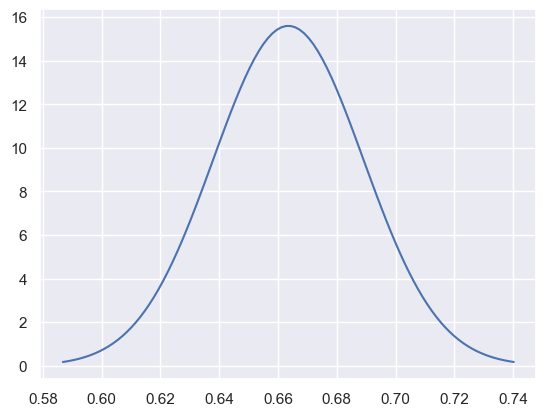

In [34]:
# calculate and divide the normal dist. range into 100 points
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plot the normal dist. based on the probability distribution function 
# values 
plt.plot(x, stats.norm.pdf(x, mu, sigma))
# save the plot in the desired directory
plt.savefig("output/model-performance/f-scores-dist.png")
plt.show()